In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
import re

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import rand
from ast import literal_eval
from matplotlib import colormaps
import squarify

from wordcloud import WordCloud
import networkx as nx
import pickle
import string
from collections import Counter, defaultdict
import operator
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
from gensim import corpora


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import os

import nltk
from nltk.corpus import PlaintextCorpusReader

In [3]:
import preprocess2
reviews_corpus = preprocess2.load_corpus('sephora_corpus')
reviews_docs = preprocess2.corpus2docs(reviews_corpus)


## Make Bigrams

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(reviews_docs, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [5]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [6]:
data_words_bigrams = make_bigrams(reviews_docs)

In [7]:
reviews_docs_joined = [" ".join(x) for x in data_words_bigrams] 

## LDA + KMeans

In [8]:
import gensim
import preprocess2
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create a Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in texts]


In [9]:
# Get Document-Word matrix
vectorizer = TfidfVectorizer()
data = vectorizer.fit_transform(reviews_docs_joined)

# Extract features
features = vectorizer.get_feature_names_out()

In [78]:
print(features)

['aa' 'aaa' 'aaaaah' ... 'zumba' 'zunc' 'zyleer']


In [10]:
def get_doc_topic(corpus, model):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=0))
        return doc_topic

In [11]:
optimal_lda_model = pickle.load(open('optimal_bigram6_lda.pkl', 'rb'))

In [12]:
lda_data = get_doc_topic(corpus, optimal_lda_model)

In [13]:
import numpy as np


def gen_init_point(docTopic, docWord, a):

    threshold = int((docTopic.shape[0] // docTopic.shape[1]) + a * docTopic.shape[0])

    # print(thershold)

    topic_mean = docTopic.mean(axis=0)
    # print(topic_mean)
    # print(topic_mean)

    support_doc_n = []
    support_doc_index = []

    for x in range(docTopic.shape[1]):
        topic = docTopic[:, x]
        res_list = topic > topic_mean[x]
        res_index = np.where(res_list == True)
        support_doc_n.append(len(res_index[0]))
        support_doc_index.append(res_index[0])

    # print(support_doc_index)
    # print(support_doc_n)
    support_doc_n = np.array(support_doc_n)
    # print(support_doc_n)
    typical_topic = np.where(support_doc_n > threshold)[0]
    # print(typical_topic)
    # print(typical_topic)

    k_clustering_init = []
    for i in typical_topic:
        # print(i)
        # print(support_doc_index[i])
        # print(dataset[support_doc_index[i]])
        k_clustering_init.append(np.asarray(docWord[support_doc_index[i]].mean(axis=0)).reshape(-1))
    return np.array(k_clustering_init)

In [19]:
import pandas as pd

def print_top_words(model, feature_names, n_top_words, path):
    print('for LDA')
    out = open(path, 'w')
    # model.components_ = lsa.inverse_transform(model.components_)
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        out.write(message+'\n')
    out.close()
    print()


def print_cluster(model, feature, n, path):
    print('for Kmeans')
    out = open(path, 'w')
    for topic_idx, topic in enumerate(model.cluster_centers_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature[i]
                             for i in topic.argsort()[:-n - 1:-1]])
        print(message)
        out.write(message+'\n')
    out.close()
    print()


def output_result(corpus, result, path):
    df = pd.DataFrame({'text': corpus, 'label': result})
    df[['text', 'label']].to_csv(path, index=False)

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def pipeline(model, n_topic, data, a, corpus, feature):
    lda = model(n_components=n_topic)
    data_lda = lda.fit_transform(data)
    print(f"Number of topics: {n_topic}")
    print(f"Alpha: {a}")
    n_init_clusters = gen_init_point(data_lda, data, a)
    
    # Check if n_init_clusters is empty, if yes, skip this iteration
    if n_init_clusters.size == 0:
        print(f"Skipping for n_topic={n_topic} and Alpha = {a} due to empty initial clusters")
        return 0  # Return None to indicate skipped iteration

    km = KMeans(n_clusters=len(n_init_clusters), init=n_init_clusters)
    km.fit_transform(data)
    
    # Check for the number of unique clusters
    unique_labels = np.unique(km.labels_)

    if len(unique_labels) > 1:
        sil_score = silhouette_score(data, km.labels_)
        print(f'Silhouette score: {sil_score}')
        print_top_words(lda, feature, 10, '_topic_word')
        print_cluster(km, feature, 10, '_cluster_meaning_{}')
        output_result(corpus, km.labels_, '_cluster_result_{}')
        return sil_score  # Return silhouette score for current iteration
    else:
        print("Only one cluster found. Cannot compute silhouette score.")
        return 0  # Return None to indicate an iteration where silhouette score couldn't be computed


In [89]:
model_results = {'Topics': [],
                 'Alpha': [],
                 'Silhouette_Score': []
                }

range_topics = list(range(2, 11))

# For KMeans initialization in your pipeline
a_values = list(np.arange(0.01, 1, 0.3))

for n_topic in range_topics:
    for a in a_values:
        sil_score = pipeline(LatentDirichletAllocation, n_topic, data, a, reviews_docs_joined, features)
        
        model_results['Topics'].append(n_topic)
        model_results['Alpha'].append(a)
        model_results['Silhouette_Score'].append(sil_score)

Number of topics: 2
Alpha: 0.01
Only one cluster found. Cannot compute silhouette score.
Number of topics: 2
Alpha: 0.31
Skipping for n_topic=2 and Alpha = 0.31 due to empty initial clusters
Number of topics: 2
Alpha: 0.61
Skipping for n_topic=2 and Alpha = 0.61 due to empty initial clusters
Number of topics: 2
Alpha: 0.9099999999999999
Skipping for n_topic=2 and Alpha = 0.9099999999999999 due to empty initial clusters
Number of topics: 3
Alpha: 0.01
Only one cluster found. Cannot compute silhouette score.
Number of topics: 3
Alpha: 0.31
Skipping for n_topic=3 and Alpha = 0.31 due to empty initial clusters
Number of topics: 3
Alpha: 0.61
Skipping for n_topic=3 and Alpha = 0.61 due to empty initial clusters
Number of topics: 3
Alpha: 0.9099999999999999
Skipping for n_topic=3 and Alpha = 0.9099999999999999 due to empty initial clusters
Number of topics: 4
Alpha: 0.01
Silhouette score: 0.004513368996453347
for LDA
Topic #0: skin love sunscreen lip product feel like moisturizer great smell

In [90]:
print (model_results['Silhouette_Score'])

[0, 0, 0, 0, 0, 0, 0, 0, 0.004513368996453347, 0, 0, 0, 0.003965305015475412, 0, 0, 0, 0.006058705187918985, 0, 0, 0, 0.005240118170880276, 0, 0, 0, 0.007796548238756226, 0, 0, 0, 0.006721734240627738, 0, 0, 0, 0.007102534925208562, 0, 0, 0]


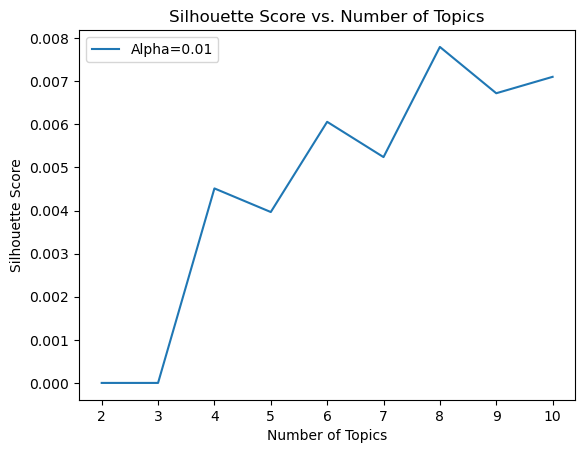

In [92]:
import matplotlib.pyplot as plt

# Extract the data for plotting
topics = model_results['Topics']
alpha_values = model_results['Alpha']
silhouette_values = model_results['Silhouette_Score']

# Filter the data for alpha = 0.01 
filtered_indices = [(alpha == 0.01) for alpha in alpha_values]

filtered_topics = [topics[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]
filtered_silhouette_values = [silhouette_values[i] for i, is_filtered in enumerate(filtered_indices) if is_filtered]

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot coherence scores for the filtered data
ax.plot(filtered_topics, filtered_silhouette_values, label='Alpha=0.01')

# Set labels and title
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs. Number of Topics')

# Display a legend
ax.legend()

# Show the plot
plt.show()


In [93]:
pd.DataFrame(model_results).to_csv('./lda_kmeans_tuning_results.csv', index=False)

In [96]:
n_topic = 8
optimal_lda_kmeans8 = pipeline(LatentDirichletAllocation,n_topic,data,0.01,corpus,features)

Number of topics: 8
Alpha: 0.01
Silhouette score: 0.006656049455087072
for LDA
Topic #0: overrated gummies dissapointed bloating sparkly que shiseido_ultimune piel rotten_egg gradual_tanning
Topic #1: product skin received sample didnt like really smell review influenster
Topic #2: skin sunscreen love product great feel moisturizer makeup like doesnt
Topic #3: skin eye cream product love feel using serum use great
Topic #4: cleanser skin face product makeup clean love use like feel
Topic #5: facial_roller pinch roller refrigerator iconic reorder obsessed_understatement supper mineral_veil nudescreen
Topic #6: skin acne product using spot week ive use love difference
Topic #7: lip balm smell like product love packaging mask formula one

for Kmeans
Topic #0: product like love skin smell face sunscreen use great makeup
Topic #1: received product influenster sample free skin review exchange_honest feel complimentary
Topic #2: skin feel love moisturizer dry product great cream make soft
Top

In [97]:
import pickle
pickle.dump(optimal_lda_kmeans8, open('optimal_lda_kmeans8.pkl', 'wb'))

In [15]:
optimal_lda_kmeans8 = pickle.load(open('optimal_lda_kmeans8.pkl', 'rb'))

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# For topics from LDA
def print_top_words_and_wordcloud(model, feature_names, n_top_words, path):
    out = open(path, 'w')
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        message = "Topic #%d: " % topic_idx + " ".join(words)
        print(message)
        out.write(message + '\n')
        
        # Generate WordCloud
        wordcloud = WordCloud().generate(' '.join(words))
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic #{topic_idx}")
        plt.show()
    out.close()

# For clusters from KMeans
def print_cluster_and_wordcloud(model, feature, n, path):
    out = open(path, 'w')
    for topic_idx, topic in enumerate(model.cluster_centers_):
        words = [feature[i] for i in topic.argsort()[:-n - 1:-1]]
        message = "Cluster #%d: " % topic_idx + " ".join(words)
        print(message)
        out.write(message + '\n')
        
        # Generate WordCloud
        wordcloud = WordCloud().generate(' '.join(words))
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Cluster #{topic_idx}")
        plt.show()
    out.close()


In [20]:
n_topic = 8
optimal_lda_kmeans8 = pipeline(LatentDirichletAllocation,n_topic,data,0.01,corpus,features)